<a href="https://colab.research.google.com/github/Deep-Learning-IGP-TUBS-SoSe2022/2022-Group03/blob/main/Assignments/02-CNN_UCM/VanillaCNN_on_UCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ------------------------------------------------

## Import required packages

In [1]:
import gc

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor, Resize
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

from PIL import Image
from datetime import datetime

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext tensorboard

# ------------------------------------------------

## Configurations

In [2]:
# Root folder for relative paths
ROOT= "/content/drive/MyDrive/DeepLearning"

# (ROOT +) Path where model should be stored
PATH_MODEL = os.path.join( ROOT, "assignments/CNN_on_UCM" )

PATH_WRITER = os.path.join( ROOT, "assignments/CNN_on_UCM/runs" )

# Path/folder where your datasets are located
DATASETS_LOCATION = os.path.join( ROOT, "datasets" )

# Define the desired image size
IMG_SIZE = 256

# Set the number of channels of the input images
IMG_DIM = 3

# Set true if you do not want to calculate mean / std again
ALREADY_CALCULATED = True 

# Percentages of validation and test subset
TEST_RATIO  = 0.2
VALID_RATIO = 0.2

# Set the batch size
BATCH_SIZE = 16

# Set how many epochs of training should be done
EPOCHS = 50

# Set learning rate(s) and momentum
LEARNING_RATES = [1e-3, 1e-4, 1e-5]
MOMENTUM = 0.9

# ------------------------------------------------

## Check GPU

In [3]:
gpu_info = !nvidia-smi

gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:

  print('Not connected to a GPU')
  
else:

  print(gpu_info)

Thu Jul  7 16:53:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Check RAM

In [5]:
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9

print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:

  print('Not using a high-RAM runtime')
  
else:

  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## Mount Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#-------------------------------------------------------------------------------

## Create class to load custom dataset

In [7]:
class CustomImageDataset(Dataset):

    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
       
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        
        return len(self.img_labels)

    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            
            image = self.transform(image)
        
        if self.target_transform:
            
            label = self.target_transform(label)
        
        return image, label

## Set paths to custom dataset (UCM)

In [8]:
# Path to folder containing images
path_img_dir = os.path.join(  DATASETS_LOCATION,
                              "ucm/UCMerced_LandUse/Images" 
                            )

# Path to .csv containing image labels
path_annotations_csv = os.path.join(  DATASETS_LOCATION,
                                      "ucm/UCMerced_LandUse/annotations.csv" 
                                    )

print( f"path to images:\t\t{ path_img_dir }" )
print( f"path to label .csv:\t{ path_annotations_csv }" )

path to images:		/content/drive/MyDrive/DeepLearning/datasets/ucm/UCMerced_LandUse/Images
path to label .csv:	/content/drive/MyDrive/DeepLearning/datasets/ucm/UCMerced_LandUse/annotations.csv


## Define transformation without knowing the normalization values


In [9]:
# Define the transformation prior to normalization
transform_no_norm  = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Resize( IMG_SIZE ),
                                          transforms.CenterCrop( IMG_SIZE ),
                                        ])

## Load / download the dataset

In [10]:
# Download the non-normalized dataset
data_not_normed = CustomImageDataset(
                                      path_annotations_csv, 
                                      path_img_dir,
                                      transform=transform_no_norm,
                                    )

print( f"UCM dataset was loaded from local disk." )

# Create DataLoader for non-normalized dataset
loader = DataLoader(
                      data_not_normed, 
                      batch_size=len( data_not_normed ),
                      num_workers=2,
                    )

UCM dataset was loaded from local disk.


## Calculate mean and std for dataset

In [11]:
# If mean and std are not yet calculated, calculate them now
if not ALREADY_CALCULATED:

  # Iterate over whole non-normalized dataset
  total_data_not_normed = next( iter( loader ) )

  # Calculate mean value (1 channel)
  mean = [
           torch.mean( total_data_not_normed[ 0 ][ :, 0 ] ),
           torch.mean( total_data_not_normed[ 0 ][ :, 1 ] ),
           torch.mean( total_data_not_normed[ 0 ][ :, 2 ] ),
          ] 

  # Calculate std (1 channel)
  std = [
           torch.std( total_data_not_normed[ 0 ][ :, 0 ] ),
           torch.std( total_data_not_normed[ 0 ][ :, 1 ] ),
           torch.std( total_data_not_normed[ 0 ][ :, 2 ] ),
          ] 

# otherwise, use values from previous calculations
else:

  # from previous calculations
  mean =[torch.tensor(0.4843), torch.tensor(0.4902), torch.tensor(0.4506)]
  std = [torch.tensor(0.2179), torch.tensor(0.2019), torch.tensor(0.1957)]

print( f"mean:\t{ mean }" )
print( f"std:\t{ std }" )

mean:	[tensor(0.4843), tensor(0.4902), tensor(0.4506)]
std:	[tensor(0.2179), tensor(0.2019), tensor(0.1957)]


## Define transformation knowing the normalization values

In [12]:
# Transformation that will be applied to the dataset
transform_w_norm = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Resize( IMG_SIZE ),
                                          transforms.CenterCrop( IMG_SIZE ),
                                          transforms.Normalize(
                                                                mean,
                                                                std
                                                                ),
                                        ]) 

## Load normalized dataset

In [13]:
# load the normalized dataset
dataset = CustomImageDataset(
                              path_annotations_csv,
                              path_img_dir,
                              transform=transform_w_norm,
                              ) 

print( f"UCM datasets was loaded from disk." )

UCM datasets was loaded from disk.


## Split dataset into train, valid and test

In [14]:
# Total number of data samples in the dataset
data_samples = len(dataset)


# Number of test samples
test_samples = int(data_samples * TEST_RATIO)

# Percentage of test data
test_perc = (test_samples / data_samples) * 100


# Number of for training
training_samples = data_samples - test_samples

# Percentage of training data (train + validation)
training_perc = (training_samples / data_samples) * 100


# Number of validation samples
valid_samples = int(training_samples * VALID_RATIO)

# Percentage of validation data
val_perc = (valid_samples / training_samples) * 100


# Number of train samples (train + validation)
train_samples = training_samples - valid_samples

# Percentage of train data
train_perc = (train_samples / training_samples) * 100

print( f"dataset samples:\t{data_samples}\n")
print( f"training samples:\t{training_samples}\t-- {training_perc:.0f} %")
print( f"test samples:\t\t{test_samples:}\t-- {test_perc:.0f} %\n")
print( f"train samples:\t\t{train_samples}\t-- {train_perc:.0f} %")
print( f"validation samples:\t{valid_samples}\t-- {val_perc:.0f} %\n")


"""
~ generator=torch.Generator().manual_seed(42)

-> used to get reproducible results while splitting datasets
"""

# Split total data into training and test subsets
training_data, test_data = random_split(  dataset,
                                          [training_samples, test_samples],
                                          generator=torch.Generator().manual_seed(42)
                                        )

# Split training data into train and validation subsets
train_data, valid_data = random_split(  training_data, 
                                        [train_samples, valid_samples],
                                        generator=torch.Generator().manual_seed(42)
                                      )

dataset samples:	2099

training samples:	1680	-- 80 %
test samples:		419	-- 20 %

train samples:		1344	-- 80 %
validation samples:	336	-- 20 %



## Visualize dataset samples

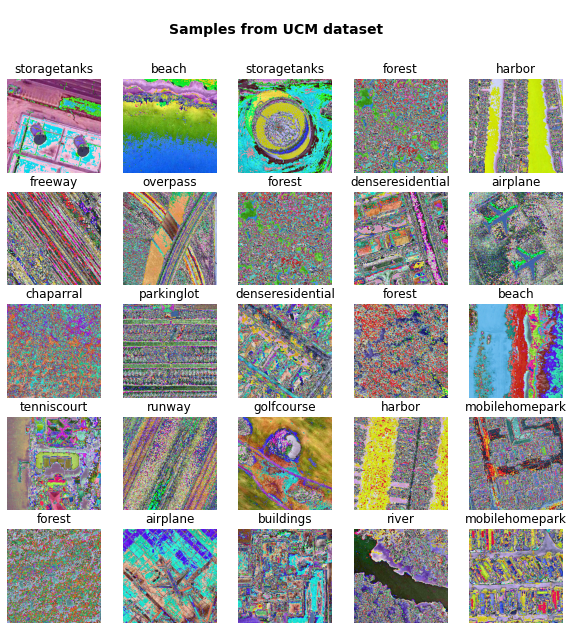

In [15]:
labels_map = {
                0: "tenniscourt",
                1: "baseballdiamond",
                2: "beach",
                3: "buildings",
                4: "chaparral",
                5: "denseresidential",
                6: "freeway",
                7: "golfcourse",
                8: "harbor",
                9: "intersection",
                10: "mediumresidential",
                11: "mobilehomepark",
                12: "overpass",
                13: "parkinglot",
                14: "river",
                15: "runway",
                16: "sparseresidential",
                17: "storagetanks",
                18: "airplane",
                19: "forest",
                20: "agricultural"
            }

figure = plt.figure( figsize=( 10, 10 ) )
figure.suptitle( "\nSamples from UCM dataset",
                 fontsize=14,
                 fontweight="bold" 
                )

cols, rows = 5, 5

for i in range( 1, cols * rows + 1 ):

    sample_idx = torch.randint( len( train_data ), size=(1, ) ).item()
    img, label = training_data[ sample_idx ]

    img = img.permute( 1, 2, 0 ).numpy()

    figure.add_subplot( rows, cols, i )

    plt.title( labels_map[ label ] )
    plt.axis( "off" )
    plt.imshow( ( img * 255 ).astype(np.uint8 ) )

plt.show()

## Setup dataloaders

In [16]:
# Create dataloaders for train, validation and test data
train_dataloader = DataLoader( train_data,
                               batch_size=BATCH_SIZE, 
                               shuffle=True,
                               generator=torch.Generator().manual_seed( 42 )
                              )

training_steps = len( train_dataloader )


validation_dataloader = DataLoader( valid_data,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    generator=torch.Generator().manual_seed( 42 ) 
                                   )

validation_steps = len( validation_dataloader )


test_dataloader = DataLoader( test_data,
                              batch_size=BATCH_SIZE
                             )

test_steps = len( test_dataloader )

#-------------------------------------------------------------------------------

## Define NN model architecture

In [17]:
from torch.nn.modules.activation import Softmax
class VanillaCNN( nn.Module ):

    def __init__( self, input_shape, dimensions, nr_outputs ):

        super( VanillaCNN, self ).__init__()

        self.output_classes = nr_outputs
        self.dropout = 0.2

        self.out_conv  = [ 32, 64, 128 ]
        self.fc_out    = [ 2500, 1500, 500, 100 ]
        self.input_fc1 = self.out_conv[2] * ( int( input_shape / ( 2 ** len( self.out_conv) ) ) ** 2 )

        self.cnn = nn.Sequential(
                                  # Input shape (UCM): 256x256x3 -- 3 channels
                                 
                                  nn.Conv2d(  in_channels=dimensions,
                                              out_channels=self.out_conv[ 0 ],
                                              kernel_size=3,
                                              padding=1,
                                              stride=1 
                                            ),
                                  # Output size from conv1: 256x256x32 -> input size for bnorm1
                                 
                                  nn.BatchNorm2d( num_features=32 ),
                                  # Output size from bnorm1 equals it's input size
                                 
                                  nn.ReLU(),
                                  # Output size of ReLU is same as it's input size
                                 
                                  #mpool1 input: 256x256x32
                                  nn.MaxPool2d( kernel_size=2, stride=2 ),
                                  # Output size of mpool1 is half it's input size: 128x128x32

                                  # conv2: Input 128x128x32
                                  nn.Conv2d(  in_channels=self.out_conv[ 0 ],
                                              out_channels=self.out_conv[ 1 ],
                                              kernel_size=3,
                                              padding=1,
                                              stride=1 
                                            ),
                                  # Output size from conv2: 128x128x64 -> input size for bnorm2
                                 
                                  nn.BatchNorm2d( num_features=64 ),
                                  # Output size from bnorm1 equals it's input size
                                 
                                  nn.ReLU(),
                                  # Output size of ReLU is same as it's input size 
                                  
                                  # mpool2 input: 128x128x64
                                  nn.MaxPool2d( kernel_size=2, stride=2 ),
                                  # Output size of mpool2 is half it's input size: 64x64x64

                                  # conv3: Input 64x64x64
                                  nn.Conv2d(  in_channels=self.out_conv[ 1 ],
                                              out_channels=self.out_conv[ 2 ],
                                              kernel_size=3,
                                              padding=1,
                                              stride=1 
                                            ),
                                  # Output size from conv2: 64x64x128 -> input size for bnorm3
                                 
                                  nn.BatchNorm2d( num_features=128 ),
                                  # Output size from bnorm1 equals it's input size
                                 
                                  nn.ReLU(),  
                                  # Output size of ReLU is same as it's input size 

                                  # mpool3 input: 64x64x128
                                  nn.MaxPool2d( kernel_size=2, stride=2 ),
                                  # Output size of mpool3 is half it's input size: 32x32x128

                                  # Flatten this output of mpool3
                                  nn.Flatten(),
                                 
                                  nn.Linear( self.input_fc1, self.fc_out[ 0 ] ),
                                  nn.Dropout( self.dropout ),
                                  nn.BatchNorm1d( self.fc_out[ 0 ] ),
                                  nn.ReLU(),
                                 
                                  nn.Linear( self.fc_out[ 0 ], self.fc_out[ 1 ] ),
                                  nn.Dropout( self.dropout ),
                                  nn.BatchNorm1d( self.fc_out[ 1 ] ),
                                  nn.ReLU(),
                                 
                                  nn.Linear( self.fc_out[ 1 ], self.fc_out[ 2 ] ),
                                  nn.Dropout( self.dropout ),
                                  nn.BatchNorm1d( self.fc_out[ 2 ] ),
                                  nn.ReLU(),
                                 
                                  nn.Linear( self.fc_out[ 2 ], self.fc_out[ 3 ] ),
                                  nn.Dropout( self.dropout ),
                                  nn.BatchNorm1d( self.fc_out[ 3 ] ),
                                  nn.ReLU(),
                                 
                                  nn.Linear( self.fc_out[ 3 ], self.output_classes ),
                                  nn.Softmax(dim=1)
                                )
        
    def forward( self, x ):

      out = self.cnn( x )

      return out

## Initiate model and loss function

In [18]:
model = VanillaCNN( IMG_SIZE, IMG_DIM, len( labels_map ) )

print( f"Current CNN used:\n\n { model }" )

total_params     = sum( p.numel() for p in model.parameters() )
trainable_params = sum( p.numel() for p in model.parameters() if p.requires_grad )

print( f"\nTotal model parameters:\t{ total_params }" )
print( f"Trainable:\t\t{ trainable_params }" )
print( f"Non-trainable:\t\t{ (total_params - trainable_params) }" )

loss_fn = torch.nn.CrossEntropyLoss()

Current CNN used:

 VanillaCNN(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=131072, out_features=2500, bias=True)
    (14): Dropout(p=0.2, inplace=False)
  

#-------------------------------------------------------------------------------

## Define training loop

In [19]:
def train_one_epoch( optimizer_obj, epoch_index, tb_writer ):
   
    running_loss = 0.
    last_loss = 0.

    correct = 0
    total = 0

    batch_idx = 0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate( train_dataloader ):

        batch_idx += 1

        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # Zero your gradients for every batch!
        optimizer_obj.zero_grad()

        # Make predictions for this batch
        outputs = model( inputs )

        # Compute the loss and its gradients
        loss = loss_fn( outputs, labels )
        loss.backward()

        # Adjust learning weights
        optimizer_obj.step()

        # Gather data and report
        running_loss += loss.item()

        _, predicted = outputs.max( 1 )
        total      += labels.size( 0 )
        correct    += predicted.eq( labels ).sum().item()

        if ( i % BATCH_SIZE ) == ( BATCH_SIZE - 1 ):

            last_loss = running_loss / BATCH_SIZE # loss per batch
            last_acc = 100. * correct / total

            last_loss_str = f"{last_loss:.4f}"
            last_acc_str  = f"{last_acc:.4f} %"

            print( f"\n\t-- curr_batch_idx: {batch_idx}\t\t|\tcurr_loss:\t{last_loss_str:10}" )
            print( f"\t-- curr_batch_idx: {batch_idx}\t\t|\tcurr_acc:\t{last_acc_str:10}\n" )

            tb_x = epoch_index * len( train_dataloader ) + i + 1

            #tb_writer.add_scalar( 'Loss/train', last_loss, tb_x )
            #tb_writer.add_scalar( 'Acc/train',  last_acc,  tb_x )

            running_loss = 0.

    return last_loss, last_acc

## Run training over epochs

In [20]:
# Set timestamp for identifying model later
timestamp = datetime.now().strftime( '%Y%m%d_%H%M%S' )

# Set up summary writer
writer = SummaryWriter()

# Memory to store training results
hists = []

for lr in LEARNING_RATES:

  model = VanillaCNN( IMG_SIZE, IMG_DIM, len( labels_map ) ).to( device )

  optimizer = torch.optim.Adam(
                                model.parameters(),
                                lr=lr,
                               )

  # Reserve memory to track training progress
  hist = {
            "train_loss" : [],
            "train_acc"  : [],
            "valid_loss" : [],
            "valid_acc"  : []
          }

  writer = SummaryWriter( 'runs/ucm_trainer_{}_{}'.format( timestamp, lr ) )

  # Current epoch number
  epoch_number = 0

  # Current best validation loss (default: 1.000.000)
  best_vloss = 1_000_000.

  # Current best validation accuracy (default: 0.0)
  best_vacc = 0.

  vcorrect   = 0
  vtotal     = 0

  # Get starting time of training
  s_since = int( round( time.time() ) )

  for epoch in range( EPOCHS ):

      print( f"\n-- EPOCH {epoch_number + 1} -- learning_rate: {lr}:\n" )

      # Make sure gradient tracking is on, and do a pass over the data
      model.train(True)

      train_loss, train_acc = train_one_epoch( optimizer, epoch_number, writer )

      # Log shuffled training loss/acc values for TensorBoard
      writer.add_scalar( f"train_loss -- lr: {lr}", train_loss, epoch )
      writer.add_scalar( f"train_acc -- lr: {lr}",  train_acc,  epoch )

      hist[ "train_loss" ].append( train_loss )
      hist[ "train_acc" ].append( train_acc )

      # We don't need gradients on to do reporting
      model.train(False)

      running_vloss = 0.0

      for i, vdata in enumerate( validation_dataloader ):

          vinputs, vlabels = vdata
          vinputs = vinputs.cuda()
          vlabels = vlabels.cuda()

          voutputs = model( vinputs )
          vloss    = loss_fn( voutputs, vlabels )

          running_vloss += vloss.item()

          _, predicted = voutputs.max( 1 )
          vtotal      += vlabels.size( 0 )
          vcorrect    += predicted.eq( vlabels ).sum().item()

      valid_loss = running_vloss / (i + 1)
      valid_acc = 100. * vcorrect / vtotal

      # Log shuffled training loss/acc values for TensorBoard
      writer.add_scalar( f"valid_loss -- lr: {lr}", valid_loss, epoch )
      writer.add_scalar( f"valid_acc -- lr {lr}",  valid_acc,  epoch )

      hist[ "valid_loss" ].append( valid_loss )
      hist[ "valid_acc" ].append( valid_acc )

      train_loss_str = f"{train_loss:.4f}"
      valid_loss_str = f"{valid_loss:.4f}"

      train_acc_str  = f"{train_acc:.4f} %"
      valid_acc_str  = f"{valid_acc:.4f} %"

      print( f"\n\t-- LOSS: train:\t{train_loss_str:10}\t|\tACC: train:\t{train_acc_str:10}" )
      print( f"\t-- LOSS: valid:\t{valid_loss_str:10}\t|\tACC: valid:\t{valid_acc_str:10}\n" )

      # Log the running loss averaged per batch
      # for both training and validation
      writer.add_scalars( f"Training vs. Validation Loss -- lr: {lr}",
                          { 'Training' : train_loss, 'Validation' : valid_loss },
                          epoch_number + 1)
      
      writer.flush()

      # Track best performance, and save the model's state
      if valid_loss < best_vloss:
          
          best_vloss_str = f"{best_vloss:.4f}"
          valid_loss_str  = f"{valid_loss:.4f}."

          best_vacc_str  = f"{best_vacc:.4f} %"
          valid_acc_str  = f"{valid_acc:.4f} %."

          print( f"\t-- Valid loss decreased from {best_vloss_str:10} to {valid_loss_str:10}" )
          print( f"\t-- Valid acc  increased from {best_vacc_str:10} to {valid_acc_str:10}\n" )

          best_vloss = valid_loss
          best_vacc  = valid_acc

          model_path = os.path.join(ROOT, PATH_MODEL, f"model_{timestamp}" )
          torch.save( model.state_dict(), model_path )

      epoch_number += 1
      
      print( "------------------------------" )

  hists.append( hist )
  
  # Free GPU memory
  model = None
  gc.collect()
  torch.cuda.empty_cache()

  # Save amount of time passed since training started
  s_time_elapsed = int( round( time.time() ) ) - s_since

  print( f"\nTraining took:\t{ s_time_elapsed } seconds." )
  print( f"Average time per epoch:\t{ s_time_elapsed / EPOCHS }\n" )

# Close summary writer
writer.close()


-- EPOCH 1 -- learning_rate: 0.001:


	-- curr_batch_idx: 16		|	curr_loss:	3.0168    
	-- curr_batch_idx: 16		|	curr_acc:	14.0625 % 


	-- curr_batch_idx: 32		|	curr_loss:	2.9835    
	-- curr_batch_idx: 32		|	curr_acc:	17.5781 % 


	-- curr_batch_idx: 48		|	curr_loss:	2.9825    
	-- curr_batch_idx: 48		|	curr_acc:	16.7969 % 


	-- curr_batch_idx: 64		|	curr_loss:	2.9478    
	-- curr_batch_idx: 64		|	curr_acc:	17.0898 % 


	-- curr_batch_idx: 80		|	curr_loss:	2.9365    
	-- curr_batch_idx: 80		|	curr_acc:	17.8125 % 


	-- LOSS: train:	2.9365    	|	ACC: train:	17.8125 % 
	-- LOSS: valid:	2.9251    	|	ACC: valid:	19.6429 % 

	-- Valid loss decreased from 1000000.0000 to 2.9251.   
	-- Valid acc  increased from 0.0000 %   to 19.6429 %.

------------------------------

-- EPOCH 2 -- learning_rate: 0.001:


	-- curr_batch_idx: 16		|	curr_loss:	2.9104    
	-- curr_batch_idx: 16		|	curr_acc:	20.3125 % 


	-- curr_batch_idx: 32		|	curr_loss:	2.8905    
	-- curr_batch_idx: 32		|	curr_acc:	22.65

#-------------------------------------------------------------------------------

## Visualizing training loss (conservative way)

Text(0.5, 1.0, 'training progress (loss over the epochs)')

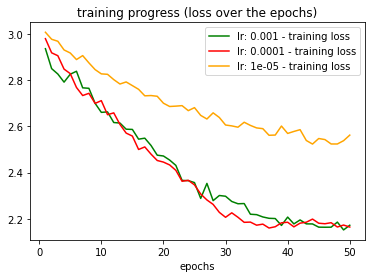

In [21]:
# visualize the training progress (loss)
x_axis_dim = np.linspace( 1, EPOCHS, EPOCHS )

colors = [ "g", "r", "orange", "blue", "brown", "fuchsia" ]

for i in range( 0, len( LEARNING_RATES ) ):

  color = colors[i]
  label = f"lr: {LEARNING_RATES[ i ]} - training loss"

  plt.plot( x_axis_dim, hists[i][ "train_loss" ], color=color, label=label )

plt.legend()

plt.xlabel( "epochs" )
plt.title( "training progress (loss over the epochs)" )

## Visualizing accuracy loss (conservative way)

Text(0.5, 1.0, 'training progress (accuracy over the epochs)')

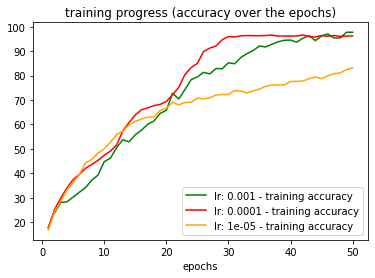

In [22]:
# visualize the training progress (accuracy)
x_axis_dim = np.linspace( 1, EPOCHS, EPOCHS )

for i in range( 0, len( LEARNING_RATES ) ):

  color = colors[i]
  label = f"lr: {LEARNING_RATES[ i ]} - training accuracy"

  plt.plot( x_axis_dim, hists[i][ "train_acc" ], color=color, label=label )

plt.legend()

plt.xlabel( "epochs" )
plt.title( "training progress (accuracy over the epochs)" ) 

## Visualizing validation loss (conservative way)

Text(0.5, 1.0, 'validation progress (loss over the epochs)')

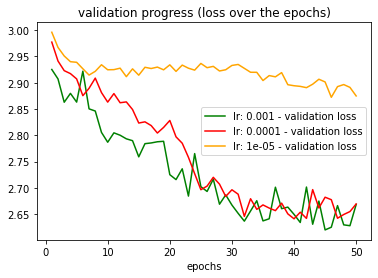

In [23]:
# visualize the validation progress (loss)
x_axis_dim = np.linspace( 1, EPOCHS, EPOCHS )

for i in range( 0, len( LEARNING_RATES ) ):

  color = colors[i]
  label = f"lr: {LEARNING_RATES[ i ]} - validation loss"

  plt.plot( x_axis_dim, hists[i][ "valid_loss" ], color=color, label=label )

plt.legend()

plt.xlabel( "epochs" )
plt.title( "validation progress (loss over the epochs)" )

## Visualizing validation accuracy (conservative way)

Text(0.5, 1.0, 'validation progress (accuracy over the epochs)')

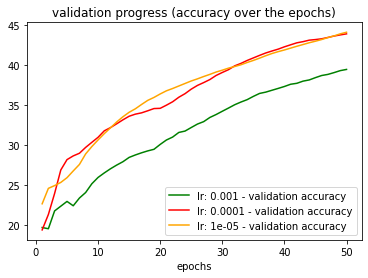

In [24]:
# visualize the validation progress (accuracy)
x_axis_dim = np.linspace( 1, EPOCHS, EPOCHS )

for i in range( 0, len( LEARNING_RATES ) ):

  color = colors[i]
  label = f"lr: {LEARNING_RATES[ i ]} - validation accuracy"

  plt.plot( x_axis_dim, hists[i][ "valid_acc" ], color=color, label=label )

plt.legend()

plt.xlabel( "epochs" )
plt.title( "validation progress (accuracy over the epochs)" )

#-------------------------------------------------------------------------------

## Testing the model on the test data

In [25]:
def test_loop( test_loader, model, loss_fn ):

    model.eval()

    size = len( test_loader.dataset )
    num_batches = len( test_loader )

    test_loss, correct = 0, 0

    with torch.no_grad():

        for X, y in test_loader:
            
            X, y = X.to( device ), y.to( device )
            pred = model( X )

            test_loss += loss_fn(pred, y).item()
            correct   += ( pred.argmax( 1 ) == y ).type( torch.float ).sum().item()

    test_loss /= num_batches
    correct   /= size

    print( f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n" )

## Visualize sample from test data

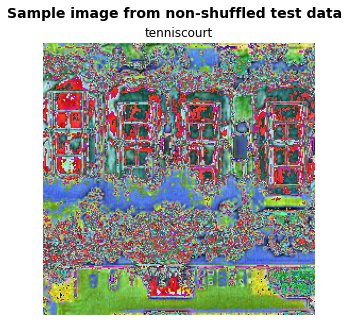

In [26]:
sample_idx = torch.randint( len( test_data ), size=( 1, ) ).item()

img, label = test_data[ sample_idx ]

img = img.permute( 1, 2, 0 ).numpy()

figure = plt.figure( figsize=( 5, 5 ) )
figure.suptitle( "Sample image from non-shuffled test data\n", fontsize=14, fontweight="bold" )

figure.add_subplot( 1, 1, 1 )

plt.axis( "off" )
plt.title( labels_map[ label ] )

plt.imshow( ( img * 255 ).astype( np.uint8 ) )

plt.show()

## Test model on test dataset

In [27]:
since = int( round( time.time() ) )

model = VanillaCNN( 256, 3, 21 ).to( device )
model.load_state_dict( torch.load( model_path ) )

test_loop( test_dataloader, model, loss_fn )

time_elapsed = int( round(time.time() ) ) - since

print( f"Testing took:\t{time_elapsed} seconds." )

Test Error: Accuracy: 52.5%, Avg loss: 2.860688 

Testing took:	6 seconds.


# ------------------------------------------------

## Visualize training progress using TensorBoard

In [ ]:
%tensorboard --logdir {PATH_WRITER}

### Using tensoboard.dev

In [29]:
!tensorboard dev upload --logdir {PATH_WRITER} \
--name "MLP_shuffle_features" \
--description "Comparison of shuffled and non-shuffled data" \
--one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/a4mJG0O8RJqS6lGlw3y62w/

[2022-07-07T17:54:44] Started scanning logdir.
[2022-07-07T17:54:44] Total uploaded: 24 scalars, 0 tensors, 0 binary objects
[2022-07-07T17:54:44] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/a4mJG0O8RJqS6lGlw3y62w/


# ------------------------------------------------